# 安裝套件

In [20]:
!apt update
!apt install chromium-chromedriver
!pip install selenium
!mkdir letters

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:5 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       
Reading state infor

# 抓Screenshot

In [21]:
# install chromium, its driver, and selenium
# set options to be headless, ..
from selenium import webdriver
options = webdriver.ChromeOptions()

#//基礎參數設置
options.add_argument('--headless')#無窗口模式
options.add_argument('--no-sandbox') #禁用沙盒模式
options.add_argument('--disable-dev-shm-usage')
# open it, go to a website, and get results

#建立瀏覽器對象,Chrome瀏覽器指定瀏覽器Firefox ：火狐Opera 歌劇院， Ie瀏覽器，Safari 蘋果瀏覽器

driver = webdriver.Chrome(options=options)
driver.get("http://siliconexam.com/st-register.php")##使用瀏覽器訪問網站



In [22]:
from selenium import webdriver
import unittest
from selenium.webdriver.common.keys import Keys
from PIL import Image
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
%matplotlib inline

In [24]:
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By
from selenium.webdriver.support import expected_conditions as EC

In [25]:
w, h = 800,700
driver.set_window_size(w, h)
driver.execute_script("window.scrollTo(0,document.body.scrollHeight);")#用execute_script方法作為驅動程序
document_height = driver.execute_script("return document.body.scrollHeight")
driver.save_screenshot('bottom.png')


captchaimage = driver.find_element(By.CLASS_NAME,"tp") #class複數定位
captchaimage = driver.find_element(By.XPATH,'//img[@id="chkimg"]') #xpath複數定位

left = captchaimage.location['x']
right = left + captchaimage.size['width']
top = h - (document_height - captchaimage.location['y'])
bottom = top + captchaimage.size['height']

img = Image.open('bottom.png')
captcha = img.crop((left, top, right, bottom))
captcha.save('captcha.png')
Image.open('captcha.png')
img = plt.imread('captcha.png')

**裁切圖片及圖片單純化**



In [26]:
def defeatCaptcha():

  image = cv2.imread('captcha.png')#讀取剛才擷取的captcha圖片
  crop=image[20:35,50:160]#把圖形不要的地方切掉，這邊切除的長寬高要自己精算，步驟比較麻煩
  hsv=cv2.cvtColor(crop,cv2.COLOR_BGR2HSV)#圖形轉換hsv顏色空間
  lower_black=np.array([0,0,0])#定義空間黑色的最小值
  upper_black=np.array([179,50,100])#定義空間黑色的最大值
  kernel = np.ones((2,2),np.uint8)#定義morphology核心

  mask = cv2.inRange(hsv, lower_black, upper_black)#把圖形遮罩出來，可過濾雜訊
  
  #利用cv2.morphologyEx將遮罩的圖形和核心進行運算，可得出closing圖形，接下來我們再用kernel把dilation的圖形取出，此時雜訊就被過濾掉了
  closing = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
  dilation = cv2.dilate(closing,kernel,iterations = 1)


  #設定內部迴圈，因為有6個文字，每個文字的寬度為20，之後再用一個list來存放6個文字的圖檔，並且用一個變數breakcode來存放6個真正的文字
  j=1 
  crops={}
  breakcode=''


  #迴圈從1到7共6個，每一個文字都被寫入從crop1.png到crop7.png。這些圖形都是從dilation，也就是處理單純化過之後的圖形來切
  for i in range(1,7):
    cv2.imwrite("crop"+str(i)+".png",dilation[4:16, j:j+9])
    crops[i]=cv2.imread("crop"+str(i)+".png")#把6個圖檔讀入list中
    breakcode+=str(getNumber(crops[i]))#把每個圖檔送入getNumber這個函數，會獲得圖檔所代表的文字，然後再把每個文字都串起來，最後成為一個長度為6的字串
    j=j+20#把j+20，這就是dilation圖檔的x字元寬度
  return breakcode#將破解完的captcha文字傳回


#mse公式實作，有了mse，就可以計算預測文字屬於這15個文字中的哪一個最可能值，之後就可以用getNumber函數來猜文字
def mse(imageA, imageB):
  err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
  err /= float(imageA.shape[0] * imageA.shape[1])
  return err



def getNumber(pic):
  min_a = 999999999#先設定最小值先為999999999，這裡隨便設定一個極大值，之後會被替換
  min_png = None #設定none值等一下來存放png
  for png in os.listdir('letters'):#建立一個迴圈，把letter目錄下的所有圖形比對一次，letters下的所有圖形是我們之前建立的那15個文字的圖
    ref = cv2.imread("letters/" + png)#循序讀取這15個圖
    if mse(ref, pic) < min_a:#ref是樣本圖，pic是captcha傳來的圖，進行mse比較，如果小於最小值的min_a，就把min_a替換成兩圈圖之間的比較值，此時再比較一次，之後把png圖檔的檔名(0~9,a~e的文字)存放在min_png中
      min_a = mse(ref, pic)
      min_png = png
    return min_png[0]#傳回文字


  

OCR


In [27]:
!pip install pytesseract
!apt install tesseract-ocr
try: 
  from PIL import Image 
except ImportError: 
  import Image 
import pytesseract
captcha = Image.open("captcha.png") 
result = pytesseract.image_to_string(captcha)
print(result)
captcha = defeatCaptcha()
print(captcha)

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 66 not upgraded.
 

NoneNoneNoneNoneNoneNone


In [28]:
!pip install pytesseract


In [29]:
!pip install pyocr

In [30]:
import pytesseract
import shutil
import os
import random
import shutil
import random
try:
 from PIL import Image
except ImportError:
 import Image
from PIL import Image
import pyocr
import cv2
from google.colab.patches import cv2_imshow

from IPython.display import Image
from IPython.display import display

img1 = Image(filename = '/content/crop1.png')
img2 = Image(filename = '/content/crop2.png')
img3 = Image(filename = '/content/crop3.png')
img4 = Image(filename = '/content/crop4.png')
img5 = Image(filename = '/content/crop5.png')
img6 = Image(filename = '/content/crop6.png')

paths = ['/content/crop1.png','/content/crop2.png',
'/content/crop3.png',
'/content/crop4.png',
'/content/crop5.png',
'/content/crop6.png']

display(img1,img2,img3,img4,img5,img6)

from PIL import Image

#分別開啟圖片
img1 = Image.open('/content/crop1.png')
img2 = Image.open('/content/crop2.png')
img3 = Image.open('/content/crop3.png')
img4 = Image.open('/content/crop4.png')
img5 = Image.open('/content/crop5.png')
img6 = Image.open('/content/crop6.png')

imgList = [img1,img2,img3,img4,img5,img6]

for item in imgList:
    print(pytesseract.image_to_string(item))

captcha test 


In [31]:
import numpy as np #將 PIL 庫讀取的影象轉換為 NumPy 陣列
import cv2
import os
from matplotlib import pyplot as plt

try:
    from PIL import Image
except ImportError:
    import Image

import pytesseract
def testcaptcha():
# some settings that I like
  plt.rcParams['figure.dpi'] = 200
  img = cv2.imread('captcha.png')
  cropped_img = img[20:35, 50:160]
  plt.imshow(cropped_img[..., ::-1])
  plt.axis('off')
  hsv = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2HSV)
  #用法：zeros(shape, dtype=float)
  lower_bound = np.zeros(3, dtype=np.uint8)#numpy.zeros()函数提供给定形状和类型的新数组, 并用零填充。
  #建立並初始化 numpy 陣列。numpy.array() 函式會將 PIL 影象轉換為 3 維陣列
  upper_bound = np.array([179, 50, 100], dtype=np.uint8)#一維陣列

  masked_img = cv2.inRange(hsv, lower_bound, upper_bound)#利用cv2.inRange函數設閾值，去除背景部分

  plt.imshow(masked_img, cmap=plt.cm.gray)

  plt.axis('off')
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

  closing_img = cv2.morphologyEx(masked_img, cv2.MORPH_CLOSE, kernel)
  dilated_img = cv2.dilate(closing_img, kernel)

  plt.imshow(dilated_img, cmap=plt.cm.gray)
  try:
    os.makedirs('./cropped', exist_ok=True)
  except OSError:
    pass

  masked_rgb = cv2.cvtColor(masked_img, cv2.COLOR_GRAY2RGB)
# masked_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
# tess_config = r'--oem 3 --psm 7'
  tess_config = r'--oem 3 --psm 1 -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyz0123456789'
  result = pytesseract.image_to_string(masked_rgb, config=tess_config)
# result = pytesseract.image_to_data(masked_rgb, config=tess_config)
  print(result)
# print(str(result))
  plt.imshow(masked_rgb)
# plt.title(str(result))
  return result  

In [32]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt

try:
    from PIL import Image
except ImportError:
    import Image

import pytesseract #機器學習


plt.rcParams['figure.dpi'] = 200 #每英吋點數


這是查看哪個部分出錯的最佳方法。 選擇感興趣區域 (ROI) 圖像處理的第一部分通常涉及獲取要處理的圖像部分。這使我們能夠降低處理能力，有時會獲得更好的結果，因為我們可以消除大部分噪音。

(-0.5, 109.5, 14.5, -0.5)

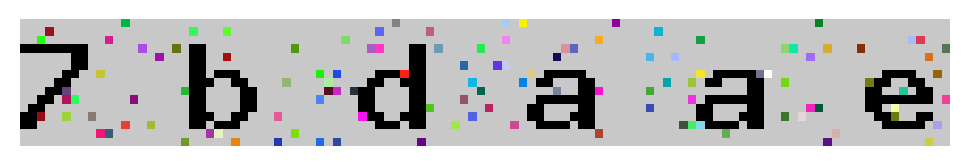

In [33]:
img = cv2.imread('captcha.png')
cropped_img = img[20:35, 50:160]

plt.imshow(cropped_img[..., ::-1])
plt.axis('off')##畫上刻度


圖像二值化 也是圖像處理中非常重要的一步。清除大部分背景並為圖像添加更多對比度，以便計算機可以輕鬆識別事物。

7 bdaae



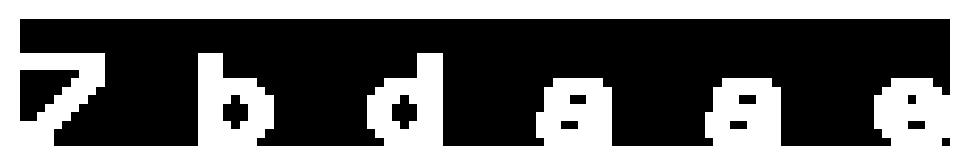

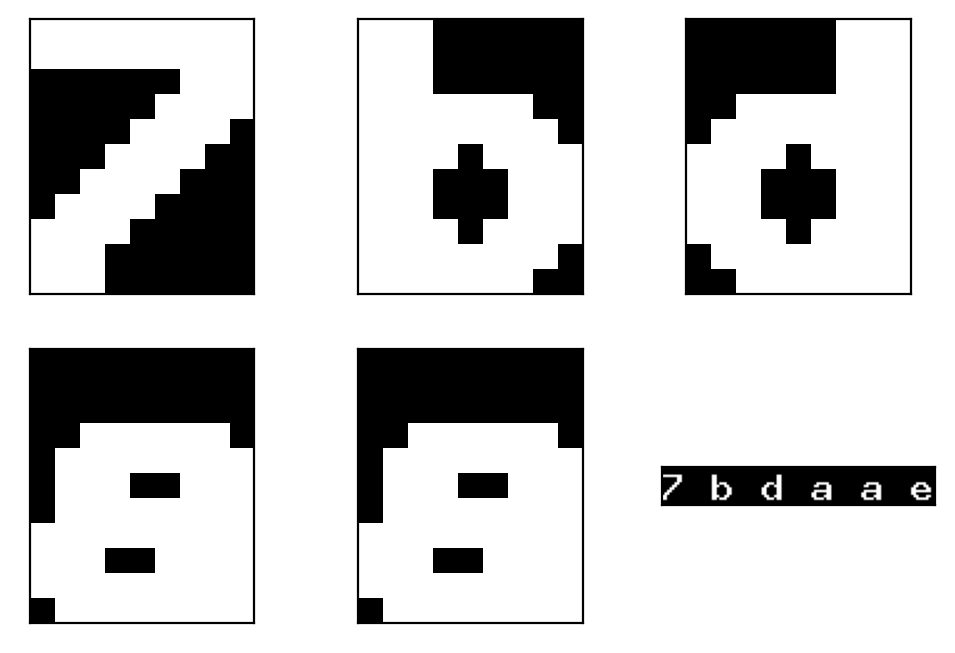

In [34]:
hsv = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2HSV)
lower_bound = np.zeros(3, dtype=np.uint8)
upper_bound = np.array([179, 50, 100], dtype=np.uint8)

masked_img = cv2.inRange(hsv, lower_bound, upper_bound)

plt.imshow(masked_img, cmap=plt.cm.gray)
plt.axis('off')

# I prefer using opencv native functions, as this
# tells people the context of what we are doing
# kernel = np.ones((2, 2), dtype=np.uint8)

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))#cv2.getStructuringElement( ) 返回指定形状和尺寸的结构元素。

closing_img = cv2.morphologyEx(masked_img, cv2.MORPH_CLOSE, kernel)
#opencv中morphologyEx()函数是一种形态学变化函数。数学形态学可以理解为一种滤波行为，因此也称为形态学滤波。
#滤波中用到的滤波器(kernal)，在形态学中称为结构元素。结构元素往往是由一个特殊的形状构成,如线条、矩形、圆等。


dilated_img = cv2.dilate(closing_img, kernel)
#腐蚀与膨胀属于形态学操作，所谓的形态学，就是改变物体的形状，形象理解一些：腐蚀=变瘦 膨胀=变胖
#主要是采用 cv2.erode() 和 cv2.dilate()，需要注意一点的是，腐蚀和膨胀主要针对二值化图像的白色部分

plt.imshow(dilated_img, cmap=plt.cm.gray)

# create directory if it doesn't exist

try:
    os.makedirs('./cropped', exist_ok=True)#os.makedirs() 方法用于递归创建目录。
except OSError:
    pass

fig, axs = plt.subplots(2, 3)
# j = 1
for i, ax in enumerate(axs.ravel()):
    # ax.imshow(dilated_img[4:16, j:j+9], cmap=plt.cm.gray)
    ax.imshow(dilated_img[4:16, i*20+1:i*20+10], cmap=plt.cm.gray)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    # j+=20
#用法： cv2.cvtColor(src, code[, dst[, dstCn]])
masked_rgb = cv2.cvtColor(masked_img, cv2.COLOR_GRAY2RGB)# cv2.cvtColor是颜色空间转换函数，masked_img是需要转换的图片，cv2.COLOR_GRAY2RGB是转换成何种格式。
# masked_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
# tess_config = r'--oem 3 --psm 7'
tess_config = r'--oem 3 --psm 1 -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyz0123456789'
result = pytesseract.image_to_string(masked_rgb, config=tess_config)#Python-tesseract功能是識別圖片檔案中文字,並作為返回引數返回識別結果
# result = pytesseract.image_to_data(masked_rgb, config=tess_config)
print(result)
# print(str(result))
plt.imshow(masked_rgb)
# plt.title(str(result))


這是查看哪個部分出錯的最佳方法。 選擇感興趣區域 (ROI) 圖像處理的第一部分通常涉及獲取要處理的圖像部分。這使我們能夠降低處理能力，有時會獲得更好的結果，因為我們可以消除大部分噪音。

In [35]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt

try:
    from PIL import Image
except ImportError:
    import Image

import pytesseract 


plt.rcParams['figure.dpi'] = 200 #每英吋點數



7 bdaae



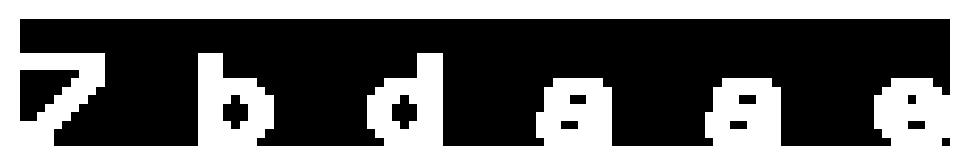

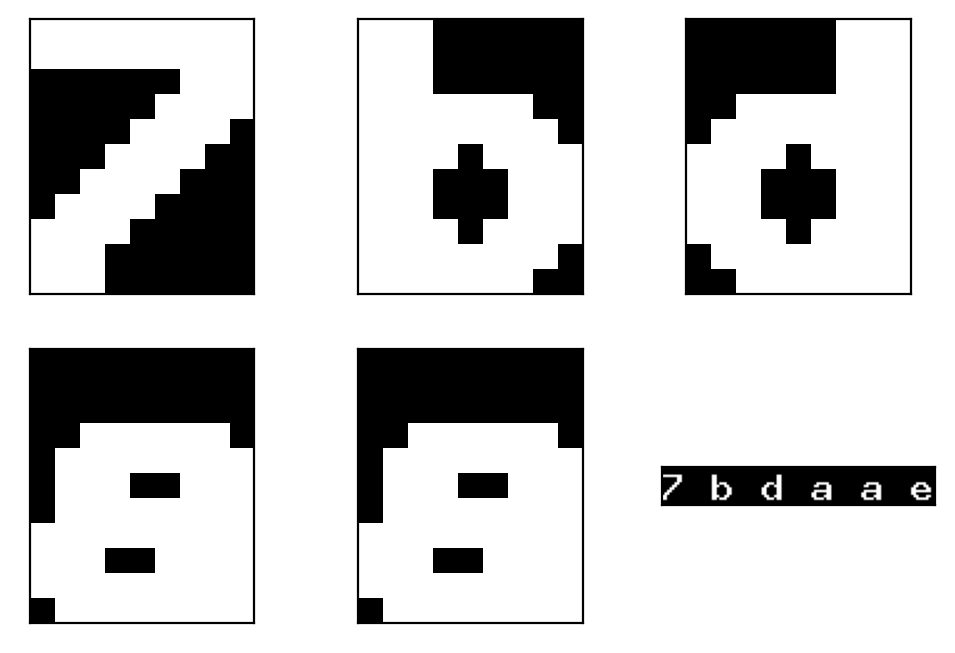

In [36]:


img = cv2.imread('captcha.png')
cropped_img = img[20:35, 50:160]#把圖形不要的地方切掉

plt.imshow(cropped_img[..., ::-1])
plt.axis('off')##畫上刻度

hsv = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2HSV)#把圖形轉換成hsv顏色空間，方便後續處理
lower_bound = np.zeros(3, dtype=np.uint8)#定義黑色最小值
upper_bound = np.array([179, 50, 100], dtype=np.uint8)#定義黑色最大值

masked_img = cv2.inRange(hsv, lower_bound, upper_bound)#把圖形遮罩出來，這動作可以過濾雜訊

plt.imshow(masked_img, cmap=plt.cm.gray)
plt.axis('off')

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))#cv2.getStructuringElement( ) 返回指定形状和尺寸的结构元素。

closing_img = cv2.morphologyEx(masked_img, cv2.MORPH_CLOSE, kernel)
#opencv中morphologyEx()函数是一种形态学变化函数。数学形态学可以理解为一种滤波行为，因此也称为形态学滤波。
#滤波中用到的滤波器(kernal)，在形态学中称为结构元素。结构元素往往是由一个特殊的形状构成,如线条、矩形、圆等。


dilated_img = cv2.dilate(closing_img, kernel)
#腐蚀与膨胀属于形态学操作，所谓的形态学，就是改变物体的形状，形象理解一些：腐蚀=变瘦 膨胀=变胖
#主要是采用 cv2.erode() 和 cv2.dilate()，需要注意一点的是，腐蚀和膨胀主要针对二值化图像的白色部分

plt.imshow(dilated_img, cmap=plt.cm.gray)

try:
    os.makedirs('./cropped', exist_ok=True)#os.makedirs() 方法用于递归创建目录。
except OSError:
    pass

fig, axs = plt.subplots(2, 3)
# j = 1
for i, ax in enumerate(axs.ravel()):
    # ax.imshow(dilated_img[4:16, j:j+9], cmap=plt.cm.gray)
    ax.imshow(dilated_img[4:16, i*20+1:i*20+10], cmap=plt.cm.gray)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    # j+=20
#用法： cv2.cvtColor(src, code[, dst[, dstCn]])
masked_rgb = cv2.cvtColor(masked_img, cv2.COLOR_GRAY2RGB)# cv2.cvtColor是颜色空间转换函数，masked_img是需要转换的图片，cv2.COLOR_GRAY2RGB是转换成何种格式。
# masked_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
# tess_config = r'--oem 3 --psm 7'
tess_config = r'--oem 3 --psm 1 -c tessedit_char_whitelist=abcdefghijklmnopqrstuvwxyz0123456789'
result = pytesseract.image_to_string(masked_rgb, config=tess_config)#Python-tesseract功能是識別圖片檔案中文字,並作為返回引數返回識別結果
# result = pytesseract.image_to_data(masked_rgb, config=tess_config)
print(result)
# print(str(result))
plt.imshow(masked_rgb)
# plt.title(str(result))

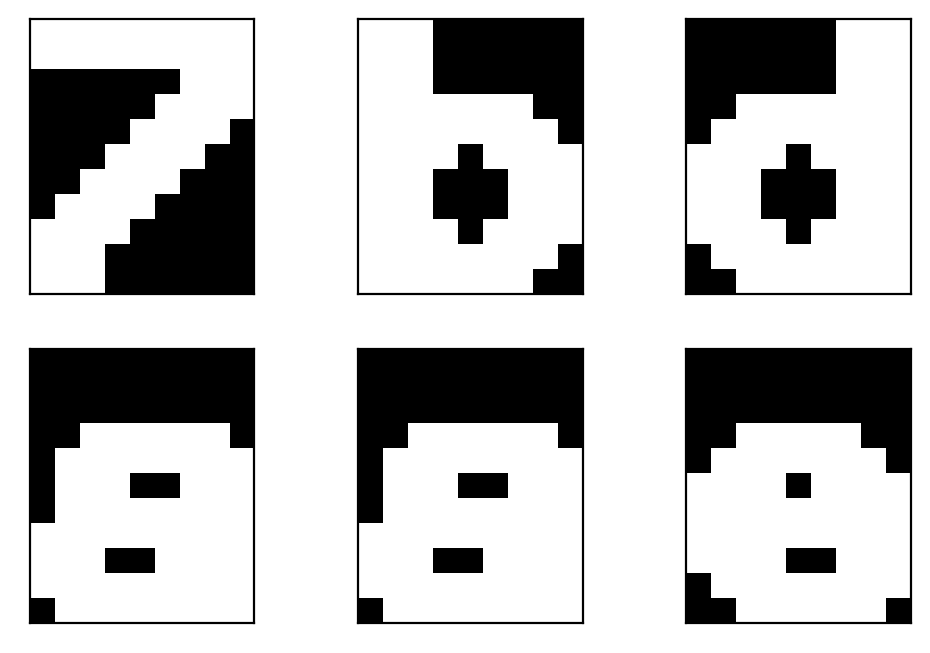

In [37]:
fig, axs = plt.subplots(2, 3)
# j = 1
for i, ax in enumerate(axs.ravel()):
    # ax.imshow(dilated_img[4:16, j:j+9], cmap=plt.cm.gray)
    ax.imshow(dilated_img[4:16, i*20+1:i*20+10], cmap=plt.cm.gray)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    # j+=20

**填寫網頁上的captcha**

7 bdaae



True

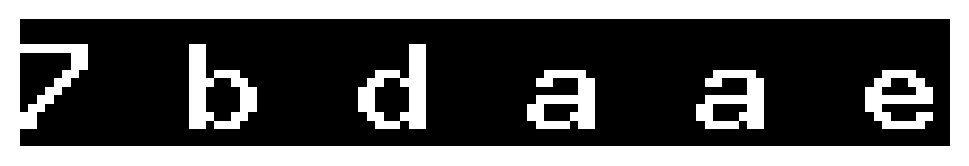

In [38]:
captcha = testcaptcha()
rvcode = driver.find_element(By.NAME,"rvcode")#用webdrive尋找填寫程式的表單，這原始碼中可以找到
rvcode.send_keys(captcha)#把剛才破解的captcha寫入表單
driver.save_screenshot('filled.png')#抓一張圖看看有沒有寫入
